In [ ]:
# install dependencies
!pip install --upgrade pip
!pip install numpy scipy gym tensorflow keras git+https://github.com/keras-rl/keras-rl.git

In [ ]:
!pip install gymnasium==0.29.1 stable-baselines3[extra]

In [ ]:
from stable_baselines3 import DQN

# Wrap env to flatten 4D obs → 1D vector
from gymnasium.wrappers import FlattenObservation

env = DynamicSyndromeEnv(d=5, p_phys=0.001, volume_depth=5)
env = FlattenObservation(env)  # converts (1,6,6,5) → (30,)

model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=1e-4,
    buffer_size=50000,
    batch_size=32,
    gamma=0.99,
)
model.learn(total_timesteps=50_000)


In [5]:
%%writefile Function_Library.py
import numpy as np

# -----------------------------
# Helper Functions for DQ-SMS
# -----------------------------

def multiplyPaulis(a, b):
    """Multiply Pauli operators: I=0, X=1, Y=2, Z=3"""
    table = [[0,1,2,3],[1,0,3,2],[2,3,0,1],[3,2,1,0]]
    return table[int(a)][int(b)]

def generate_error(d, p_phys, error_model="DP"):
    """Generate physical error configuration on dxd lattice"""
    error = np.zeros((d, d), int)
    for i in range(d):
        for j in range(d):
            if np.random.rand() < p_phys:
                if error_model == "X":
                    error[i, j] = 1
                elif error_model == "DP":
                    error[i, j] = np.random.randint(1, 4)
                elif error_model == "IIDXZ":
                    X_err = np.random.rand() < p_phys
                    Z_err = np.random.rand() < p_phys
                    if X_err and Z_err:
                        error[i, j] = 2
                    elif X_err:
                        error[i, j] = 1
                    elif Z_err:
                        error[i, j] = 3
    return error

def generate_surface_code_syndrome(error, qubits):
    """Compute stabilizer violations (syndrome)"""
    d = error.shape[0]
    syndrome = np.zeros((d+1, d+1), int)
    for i in range(d):
        for j in range(d):
            if error[i, j] != 0:
                for k in range(qubits.shape[2]):
                    if qubits[i, j, k, 2] not in [0, error[i, j]]:
                        a, b = int(qubits[i, j, k, 0]), int(qubits[i, j, k, 1])
                        syndrome[a, b] ^= 1
    return syndrome


Writing Function_Library.py


In [7]:
import gym
import numpy as np
from gym import spaces
from Function_Library import generate_error, generate_surface_code_syndrome

class DynamicSyndromeEnv(gym.Env):
    """Environment for Dynamic Syndrome Measurement Scheduling"""

    metadata = {"render.modes": ["human"]}

    def __init__(self, d=5, p_phys=0.001, error_model="DP", volume_depth=5):
        super(DynamicSyndromeEnv, self).__init__()
        self.d = d
        self.p_phys = p_phys
        self.error_model = error_model
        self.volume_depth = volume_depth

        # State: syndrome volume (binary tensor)
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(1, d+1, d+1, volume_depth), dtype=np.int32
        )

        # Actions: choose stabilizer (index flattened)
        self.num_actions = (d+1)*(d+1)
        self.action_space = spaces.Discrete(self.num_actions)

        self.reset()

    def reset(self):
        self.error = generate_error(self.d, self.p_phys, self.error_model)
        self.syndrome_volume = np.zeros((1, self.d+1, self.d+1, self.volume_depth), int)
        self.t = 0
        return self.syndrome_volume

    def step(self, action):
        # Action = choose stabilizer to measure
        row = action // (self.d+1)
        col = action % (self.d+1)

        # measure syndrome (simulate noisy measurement)
        syndrome = generate_surface_code_syndrome(self.error, np.zeros((self.d, self.d, 4, 3)))
        measured_value = syndrome[row, col]

        # update syndrome volume
        self.syndrome_volume = np.roll(self.syndrome_volume, -1, axis=3)
        self.syndrome_volume[0, row, col, -1] = measured_value

        # reward = negative penalty if logical failure occurs
        reward = 0
        done = False
        self.t += 1
        if self.t > 200:  # max steps
            done = True
        return self.syndrome_volume, reward, done, {}


In [13]:
%%writefile DynamicSyndromeEnv.py
import gym
import numpy as np
from gym import spaces
from Function_Library import generate_error, generate_surface_code_syndrome

class DynamicSyndromeEnv(gym.Env):
    """Dynamic Syndrome Measurement Scheduling Env for SB3"""

    def __init__(self, d=5, p_phys=0.001, error_model="DP", volume_depth=5):
        super(DynamicSyndromeEnv, self).__init__()
        self.d = d
        self.p_phys = p_phys
        self.error_model = error_model
        self.volume_depth = volume_depth

        # Observation: (channels, height, width, depth) → SB3 expects float32
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(1, d+1, d+1, volume_depth), dtype=np.float32
        )

        # Actions: choose stabilizer (flattened index)
        self.action_space = spaces.Discrete((d+1) * (d+1))

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.error = generate_error(self.d, self.p_phys, self.error_model)
        self.syndrome_volume = np.zeros(
            (1, self.d+1, self.d+1, self.volume_depth), dtype=np.float32
        )
        self.t = 0
        return self.syndrome_volume, {}

    def step(self, action):
        row = action // (self.d+1)
        col = action % (self.d+1)

        # measure syndrome (fake qubits placeholder for now)
        syndrome = generate_surface_code_syndrome(
            self.error, np.zeros((self.d, self.d, 4, 3))
        )
        measured_value = syndrome[row, col]

        # update syndrome volume
        self.syndrome_volume = np.roll(self.syndrome_volume, -1, axis=3)
        self.syndrome_volume[0, row, col, -1] = measured_value

        reward = 0.0
        self.t += 1
        done = self.t >= 200
        return self.syndrome_volume.astype(np.float32), reward, done, False, {}


Writing DynamicSyndromeEnv.py


In [1]:
%%writefile Environments.py
import gymnasium as gym
import numpy as np
from gymnasium import spaces
from Function_Library import generate_error, generate_surface_code_syndrome

class DynamicSyndromeEnv(gym.Env):
    """Dynamic Syndrome Measurement Scheduling Env for SB3"""

    def __init__(self, d=5, p_phys=0.001, error_model="DP", volume_depth=5):
        super(DynamicSyndromeEnv, self).__init__()
        self.d = d
        self.p_phys = p_phys
        self.error_model = error_model
        self.volume_depth = volume_depth

        # SB3 expects float32 obs
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(1, d+1, d+1, volume_depth), dtype=np.float32
        )
        self.action_space = spaces.Discrete((d+1) * (d+1))

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.error = generate_error(self.d, self.p_phys, self.error_model)
        self.syndrome_volume = np.zeros(
            (1, self.d+1, self.d+1, self.volume_depth), dtype=np.float32
        )
        self.t = 0
        return self.syndrome_volume, {}

    def step(self, action):
        row = action // (self.d+1)
        col = action % (self.d+1)

        syndrome = generate_surface_code_syndrome(
            self.error, np.zeros((self.d, self.d, 4, 3))
        )
        measured_value = syndrome[row, col]

        self.syndrome_volume = np.roll(self.syndrome_volume, -1, axis=3)
        self.syndrome_volume[0, row, col, -1] = measured_value

        reward = 0.0
        self.t += 1
        terminated = self.t >= 200
        truncated = False
        return self.syndrome_volume.astype(np.float32), reward, terminated, truncated, {}

Overwriting Environments.py


In [5]:
import numpy as np
from Environments import DynamicSyndromeEnv
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from gymnasium.wrappers import FlattenObservation

# Create environment
env = DynamicSyndromeEnv(d=5, p_phys=0.001, volume_depth=5)

# Flatten 4D observation to 1D for MLPPolicy
env = FlattenObservation(env)

# Sanity check
check_env(env, warn=True)

# Build DQN agent with MLP policy
model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-4,
    buffer_size=50000,
    batch_size=32,
    gamma=0.99,
    train_freq=1,
    target_update_interval=5000,
    exploration_fraction=0.2,
    exploration_final_eps=0.02,
    verbose=1,
    tensorboard_log="./dq_sms_tensorboard/"
)

# Train
model.learn(total_timesteps=100_000)

# Save
model.save("dq_sms_dqn")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./dq_sms_tensorboard/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 567      |
|    time_elapsed     | 1        |
|    total_timesteps  | 800      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.000326 |
|    n_updates        | 699      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.922    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 476      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1600

In [7]:
from stable_baselines3.common.callbacks import EvalCallback
from Environments import DynamicSyndromeEnv
from gymnasium.wrappers import FlattenObservation
from stable_baselines3 import DQN
import matplotlib.pyplot as plt

# Create environment
train_env = FlattenObservation(DynamicSyndromeEnv(d=5, p_phys=0.001, volume_depth=5))
eval_env = FlattenObservation(DynamicSyndromeEnv(d=5, p_phys=0.001, volume_depth=5))

# Callback to evaluate every 5000 steps
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/",
    log_path="./logs/",
    eval_freq=5000,
    n_eval_episodes=5,
    deterministic=True,
)

model = DQN(
    "MlpPolicy",
    train_env,
    verbose=1,
    learning_rate=1e-4,
    buffer_size=50000,
    batch_size=32,
    gamma=0.99
)

# Train with evaluation callback
model.learn(total_timesteps=50000, callback=eval_callback)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1571     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00807  |
|    n_updates        | 174      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 905      |
|    time_elapsed     | 1        |
|    total_timesteps  | 1600     |
| train/              |        

Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1732     |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00661  |
|    n_updates        | 174      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 200      |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1058     |
|    time_elapsed     | 1        |
|    total_timesteps  | 1600     |
| train/              |          |
|    learning_rate    | 0.0001   |
|  

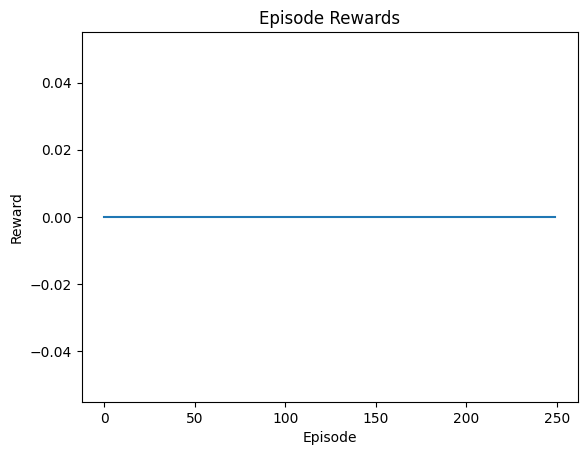

In [9]:
from stable_baselines3.common.monitor import Monitor

env = Monitor(train_env)  # Wrap env to record episode rewards

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

# Rewards
plt.plot(env.get_episode_rewards())
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards")
plt.show()
